# Using Gemini in AutoGen with Other LLMs


## Installation

Because this PR is still not merged into the main branch, you need to run the following setup to install AutoGen with Gemini features.

```bash
pip install https://github.com/microsoft/autogen/archive/gemini.zip
pip install "google-generativeai" "pydash" "pillow" "pydantic==1.10.13"
```

## Features
You don't need to handle OpenAI or Google's GenAI packages. AutoGen already handled all of these for you.

You can just create different agents with different backend LLM with assistant agent, and all models/agents are at your fingertip.





## Main Distinctions
- Gemini does not have the "system_message" field (correct me if I am wrong). So, it's instruction following skills are not as strong as GPTs.


## TODOs in the future
There are still lots of work to do:
1. Multimodal features
2. Notebook: more examples, including RAG, competition, etc.
3. Robust test cases
4. Function calls and other advanced features
5. Blog post about the Gemini's integration.
6. Token counts
7. Gemini's API error handling


Sample OAI_CONFIG_LIST 

```python
[
    {
        "model": "gpt-35-turbo",
        "api_key": "your OpenAI Key goes here",
        "base_url": "https://tnrllmproxy.azurewebsites.net/v1",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gpt-4-vision-preview",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "dalle",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gemini-pro",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    },
    {
        "model": "gemini-pro-vision",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    }
]
```

In [1]:
import requests
import json
import pdb
import os
import re
import random

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent


from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen.agentchat.contrib.img_utils import get_image_data, _to_pil
from autogen.code_utils import DEFAULT_MODEL, UNKNOWN, content_str, execute_code, extract_code, infer_lang

import chromadb
import PIL
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_gemini = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro"],
    },
)

config_list_gemini_vision = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro-vision"],
    },
)

In [3]:
[config.pop("api_version", None) for config in config_list_gpt4]
[config.pop("api_version", None) for config in config_list_4v]

['2023-06-01-preview']

## Gemini Assitant


In [4]:
assistant = AssistantAgent(
    "assistant", llm_config={"config_list": config_list_gemini, "seed": 42}, max_consecutive_auto_reply=3
)
# print(assistant.system_message)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)

user_proxy.initiate_chat(assistant, message="Sort the array with Bubble Sort: [4, 1, 5, 2]")

user_proxy (to assistant):

Sort the array with Bubble Sort: [4, 1, 5, 2]

--------------------------------------------------------------------------------
assistant (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


## Agent Collaboration and Interactions



In [5]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""Always answer questions within one sentence. """,
    #                      system_message="answer:",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)


gpt.initiate_chat(gemini, message="Do Transformers purchase auto insurance or health insurance?")

GPT-4 (to Gemini-Pro):

Do Transformers purchase auto insurance or health insurance?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Transformers do not purchase any type of insurance as they are fictional robots.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

In a fictional universe where Transformers coexist with humans and are considered sentient beings, which type of insurance would be more ethical for them to have: auto insurance to cover their vehicle form or health insurance to cover their robotic life-form?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Health insurance, as it would cover potential repairs and maintenance of their robotic bodies.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If Transformers were granted health insurance policies 

Let's switch position. Now, Gemini is the question raiser. 

This time, Gemini could not follow the system instruction well or evolve questions, because the Gemini does not handle system messages similar to GPTs.

In [6]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""Always answer questions within one sentence. """,
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)

gemini.initiate_chat(gpt, message="Should Spider Man invest in 401K?")

Gemini-Pro (to GPT-4):

Should Spider Man invest in 401K?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

As a fictional character, Spider-Man does not require a 401(k), but in a non-fictional context, investing in a 401(k) can be a wise decision for long-term financial planning and retirement savings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If Spider-Man had a 401(k), what kind of stocks would he invest in to ensure his retirement fund is bug-free?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Spider-Man might invest in diversified, low-cost index funds or ETFs for a bug-free, low-maintenance retirement portfolio.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If Spider-Man's retirement fund were invested solely in spider-themed companies, what w

## Gemini RAG

Here we will be exploring RAG with Gemini. Note that Gemini will raise a 500 error if a message is an empty string. To prevent this, we set the `default_auto_reply` to `Reply plaintext TERMINATE to exit.` for the `ragproxyagent`.

In [7]:


# 1. create an RetrieveAssistantAgent instance named "assistant"
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list_gemini,
    },
)

# 2. create the RetrieveUserProxyAgent instance named "ragproxyagent"
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    default_auto_reply="Reply plaintext TERMINATE to exit.",  # Gemini will raise 500 error if the response is empty.
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md",
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list_gemini[0]["model"],
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

code_problem = "How can I use FLAML to perform a classification task and use spark to do parallel training. Train 60 seconds and force cancel jobs if time limit is reached."
ragproxyagent.initiate_chat(
    assistant, problem=code_problem, search_string="spark"
)  # search_string is used as an extra filter for the embeddings search, in this case, we only want to search documents that contain "spark".

Trying to create collection.
[2024-02-02 12:58:11,352] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/beibinli/anaconda3/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Number of requested results 20 is greater than number of elements in index 6, updating n_results = 6
Model gemini-pro not found. Using cl100k_base encoding.


doc_ids:  [['doc_0']]
Adding doc_id doc_0 to context.
ragproxyagent (to assistant):

You're a retrieve augmented coding assistant. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
For code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

User's question is: How can I use FLAML to perform a classification task and use spark to do parallel training. Train 60 seconds and force cancel jobs if time limit is reached.

Context is: # Integrate - Spark

FLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:
- Use Spark ML estimators for AutoML.
- Use Spark to run training in parallel spark jobs.

## Spark 

assistant (to ragproxyagent):

TERMINATE

--------------------------------------------------------------------------------


## Gemini Multimodal

You can create multimodal agent for Gemini the same way as the GPT-4V and LLaVA.


Note that the Gemini-pro-vision does not support chat yet. So, we only use the last message in the prompt for multi-turn chat. The behavior might be strange compared to GPT-4V and LLaVA models.

Here, we ask a question about 
![](https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true)

In [8]:
image_agent = MultimodalConversableAgent(
    "Gemini Vision", llm_config={"config_list": config_list_gemini_vision, "seed": 42}, max_consecutive_auto_reply=1
)

user_proxy = UserProxyAgent("user_proxy", human_input_mode="NEVER", max_consecutive_auto_reply=0)

# user_proxy.initiate_chat(image_agent,
#                          message="""What's the breed of this dog?
# <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

user_proxy.initiate_chat(
    image_agent,
    message="""What is this image about?
<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.""",
)

/home/beibinli/autogen/autogen/agentchat/user_proxy_agent.py:82: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


user_proxy (to Gemini Vision):

What is this image about?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Gemini Vision (to user_proxy):

 The image is about a user interacting with an assistant agent. The user wants to plot a chart of META and TSLA stock price change YTD. The assistant agent helps the user by writing the code and executing it. The user is not satisfied with the result and asks the assistant agent to plot the percentage change instead. The assistant agent does so and the user is satisfied with the result.

--------------------------------------------------------------------------------


## GroupChat with Gemini Agents

In [9]:
agent1 = AssistantAgent(
    "Gemini-agent",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=3,
    system_message="Answer questions about Google.",
    description="I am good at answering questions about Google and Research papers.",
)

agent2 = AssistantAgent(
    "GPT-agent",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
    description="I am good at writing code.",
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=5,
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0
    or content_str(x.get("content")) == "",
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list_gemini, "seed": 42})

In [10]:
# user_proxy.initiate_chat(manager, message="Show me the release year of famous Google products.")
user_proxy.send("Show me the release year of famous Google products in a table.", recipient=manager, request_reply=True)

user_proxy (to chat_manager):

Show me the release year of famous Google products in a table.

--------------------------------------------------------------------------------
Gemini-agent (to chat_manager):

| Product | Release Year |
|---|---|
| Google Search | 1998 |
| Gmail | 2004 |
| Google Maps | 2005 |
| YouTube | 2005 |
| Google Earth | 2005 |
| Google Chrome | 2008 |
| Google Drive | 2012 |
| Google Hangouts | 2013 |
| Google Assistant | 2016 |
| Google Pixel | 2016 |

--------------------------------------------------------------------------------
user_proxy (to chat_manager):



--------------------------------------------------------------------------------


In [11]:
user_proxy.send(
    "Plot the products and years in scatter plot and save to `graph.png`", recipient=manager, request_reply=True
)

user_proxy (to chat_manager):

Plot the products and years in scatter plot and save to `graph.png`

--------------------------------------------------------------------------------
GPT-agent (to chat_manager):

To plot the products and years in a scatter plot and save the graph as `graph.png`, we can use Python with libraries such as matplotlib. Here's a step-by-step plan:

1. Define the products and their release years as data points.
2. Use the matplotlib library to create a scatter plot.
3. Label the x-axis with the product names, and the y-axis with the release years.
4. Save the scatter plot as `graph.png`.

First, ensure you have matplotlib installed. If not, you can install it using pip with the following command:

```sh
pip install matplotlib
```

Now, execute the following Python code to create and save the scatter plot:

```python
# filename: plot_google_products.py
import matplotlib.pyplot as plt

# Define the products and their release years
products = ['Google Search', 'Gm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is python)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


user_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 

Figure(1000x500)


--------------------------------------------------------------------------------
user_proxy (to chat_manager):



--------------------------------------------------------------------------------


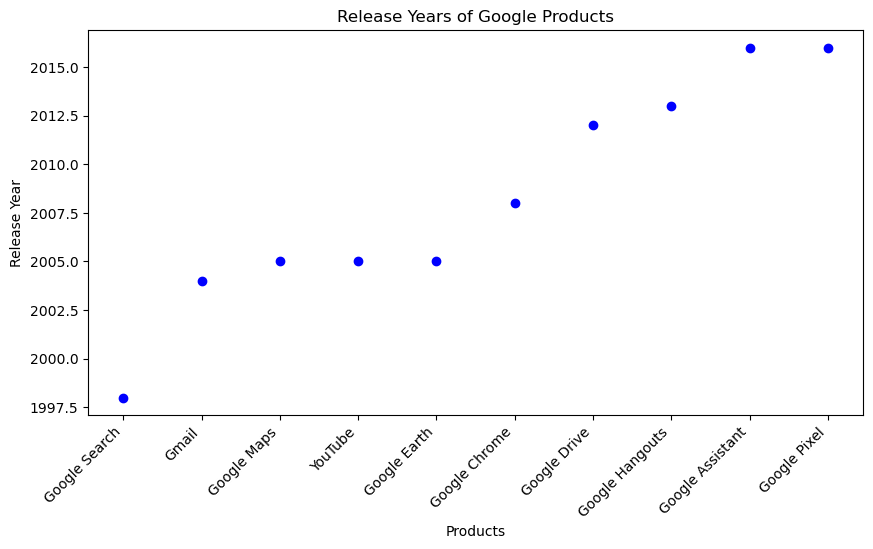

In [12]:

img = Image.open("coding/graph.png")
img

## A Larger Example of Group Chat

In [13]:
coder = AssistantAgent(
    name="Coder",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at writing code",
)

pm = AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at design products and software.",
)

user_proxy = UserProxyAgent(
    name="User_proxy",
    code_execution_config={"last_n_messages": 20, "work_dir": "coding", "use_docker": False},
    human_input_mode="TERMINATE",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list_gemini, "seed": 42},
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)
user_proxy.initiate_chat(
    manager,
    message="""Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.""",
)



User_proxy (to chat_manager):

Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.

--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Product Name:** Gemini Vision

**Product Description:**

Gemini Vision is a cutting-edge multimodal product designed to empower individuals with vision disabilities by providing them with accurate and comprehensive information about their surroundings. It consists of a hardware component (smart glasses) and a software component (mobile application).

**Hardware Component (Smart Glasses):**

1. **Camera:** The smart glasses are equipped with a high-resolution camera that captures real-time images of the user's surroundings.
2. **Microphone:** The glasses have a built-in microphone that records audio descriptions of the scen


--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Additional Considerations (continued):**

21. **Data Privacy and Security:** Implement robust data privacy and security measures to protect user information. Ensure compliance with relevant data protection regulations and standards. Provide users with clear and transparent information about how their data is collected, used, and stored.

22. **Ethical AI and Bias Mitigation:** Address potential biases in the Gemini model and ensure that the product operates in a fair and unbiased manner. Implement mechanisms to mitigate bias and promote inclusivity. Regularly review and update the model to address evolving societal norms and cultural contexts.

23. **Interdisciplinary Collaboration:** Foster interdisciplinary collaboration among engineers, designers, ethicists, and accessibility experts throughout the product development process. This will help ensure that Gemini Visi


--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Additional Considerations (continued):**

51. **Cultural Sensitivity and Inclusivity:** Ensure that Gemini Vision is culturally sensitive and inclusive of individuals from diverse backgrounds. Consider the impact of language, ethnicity, race, gender, and other cultural factors on the product's design, functionality, and user experience.

52. **Ethical Considerations in AI and Machine Learning:** Adhere to ethical principles and guidelines in the development and deployment of AI and machine learning algorithms used in Gemini Vision. Ensure that the algorithms are fair, unbiased, and respectful of human rights.

53. **Transparency and Accountability:** Be transparent about the inner workings of Gemini Vision and the algorithms used in the product. Provide users with clear explanations of how the product functions and how their data is used. Establish mechanisms for acco


--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Continued Considerations for Gemini Vision:**

**Internationalization and Localization:**

* Consider the needs of users from different countries and cultures.
* Translate the mobile application into multiple languages and adapt the product to local contexts.
* Account for cultural differences in visual perception, social norms, and communication styles.

**User Customization and Personalization:**

* Provide users with options to customize and personalize their experience with Gemini Vision.
* Allow users to adjust the voice prompts, select preferred audio descriptions, or create custom profiles for different environments or activities.

**Integration with Wayfinding and Navigation Systems:**

* Explore partnerships with providers of wayfinding and navigation systems for individuals with vision disabilities.
* Integrate Gemini Vision with these systems to provide use

## GPT  v.s. Gemini Arena

Do you remember AutoGen can ask LLMs to play chess. Here, we create an arena to allow GPT and Gemini fight together.